# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")


In [11]:
correlations[survey_fields].sort_values(ascending=False)

N_s           0.423463
N_p           0.421530
aca_s_11      0.339435
saf_s_11      0.337639
saf_tot_11    0.318753
saf_t_11      0.313810
N_t           0.291463
rr_s          0.232199
eng_s_11      0.213822
aca_tot_11    0.190966
com_s_11      0.187370
aca_t_11      0.132348
saf_p_11      0.122913
eng_tot_11    0.100102
com_t_11      0.082419
com_tot_11    0.077310
rr_p          0.047925
eng_t_11      0.036906
aca_p_11      0.035155
eng_p_11      0.020254
rr_t         -0.023386
com_p_11     -0.115073
Name: sat_score, dtype: float64

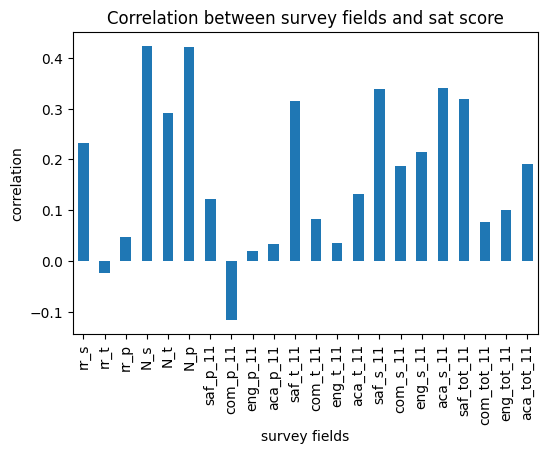

In [12]:
correlations[survey_fields].plot.bar()
plt.xlabel('survey fields')
plt.ylabel('correlation')
plt.title('Correlation between survey fields and sat score')
plt.show()


We can observe that saf_t_11 and saf_s_11 columns, which accords to safety in school are strongly correlated with sat score.

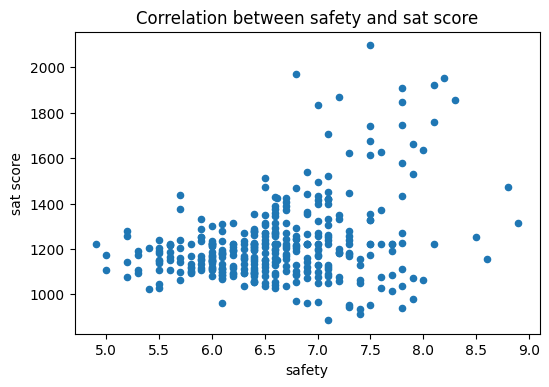

In [13]:
combined.plot.scatter(x='saf_s_11', y='sat_score')
plt.title('Correlation between safety and sat score')
plt.xlabel('safety')
plt.ylabel('sat score')
plt.show()

In general, the more safety school is the better sat scores are, so correlation is positive but not strongly.

In [14]:
safety_avg=combined.groupby('boro').agg(np.mean)
borough_safety=safety_avg['saf_s_11']
borough_safety

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

Manhattan is the safest and Brooklyn the least safe borough.

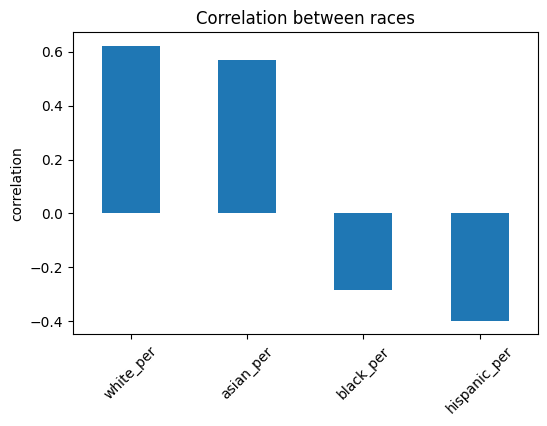

In [15]:
correlations[['white_per', 'asian_per', 'black_per', 'hispanic_per']].plot.bar()
plt.title('Correlation between races')
plt.ylabel('correlation')
plt.xticks(rotation=45)
plt.show()

It can be seen that white and asian people have higher sat scores than black and hispanic people.

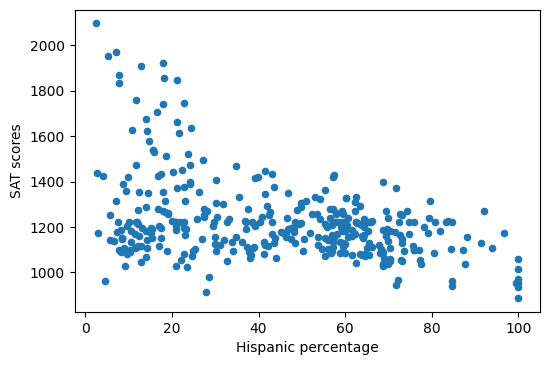

In [16]:
combined.plot.scatter(x='hispanic_per', y='sat_score')
plt.xlabel('Hispanic percentage')
plt.ylabel('SAT scores')
plt.show()

As we can see, the more Hispanic people are in school, the worse SAT scores are. Schools with Hispanic people up to ~25% have actually very good scores, but there are some when they are still low. It shows us weakly negative correlation.

In [26]:
hispanic_per_95 = combined[combined['hispanic_per']>95]
hispanic_per_95[["SCHOOL NAME", "hispanic_per", "sat_score"]]bbbbb


,SCHOOL NAME,hispanic_per,sat_score
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8,1058.0
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7,1174.0
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8,1014.0
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4,951.0
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8,934.0
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8,970.0
253,MULTICULTURAL HIGH SCHOOL,99.8,887.0
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0,951.0


Most of the schools in the list have more than 95% of their student population being hispanic as they are set up to cater for new immigrants which majority are from Spanish-speaking countries, reason why the SAT Scores are low.

In [34]:
hispanic_per_10=combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]
hispanic_per_10[['SCHOOL NAME', 'hispanic_per','sat_score']]

,SCHOOL NAME,hispanic_per,sat_score
37,STUYVESANT HIGH SCHOOL,2.4,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,7.2,1969.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,7.9,1833.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,7.9,1868.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,5.3,1953.0


Those schools are known of having high academic standards, but it still does not explain why there are that little hispanic students.

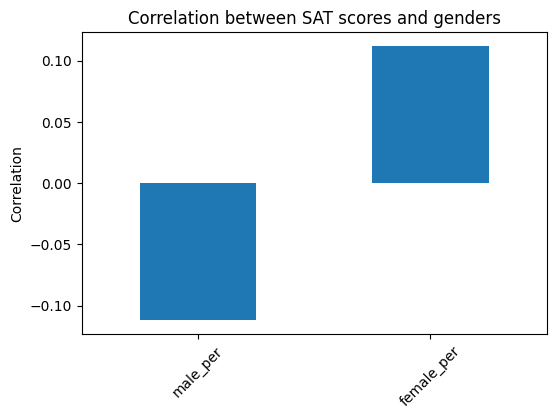

In [58]:
male_female_cor = correlations[['male_per', 'female_per']]
male_female_cor.plot.bar()
plt.ylabel('Correlation')

plt.xticks(rotation=45)
plt.title('Correlation between SAT scores and genders')
plt.show()

Text(0, 0.5, 'SAT scores')

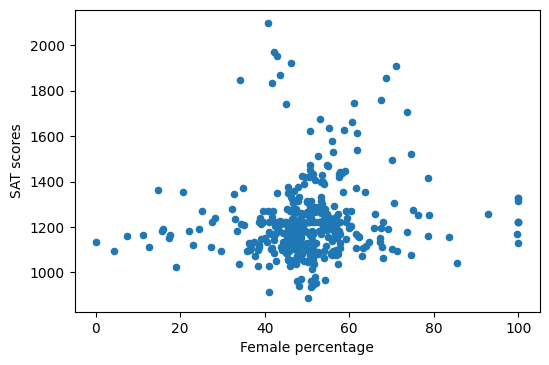

In [54]:
combined.plot.scatter(x='female_per', y='sat_score')
plt.xlabel('Female percentage')
plt.ylabel('SAT scores')

Schools with bigger female percentage have slighly better SAT scores.

In [48]:
female_high=combined[(combined['female_per']>60) & (combined['sat_score'] > 1700)]
female_high[['SCHOOL NAME', 'female_per', 'sat_score']]

,SCHOOL NAME,female_per,sat_score
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,1758.0
60,BEACON HIGH SCHOOL,61.0,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,1707.0
302,TOWNSEND HARRIS HIGH SCHOOL,71.1,1910.0


These schools are highly liberal with equally high academic standards.

In [62]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']


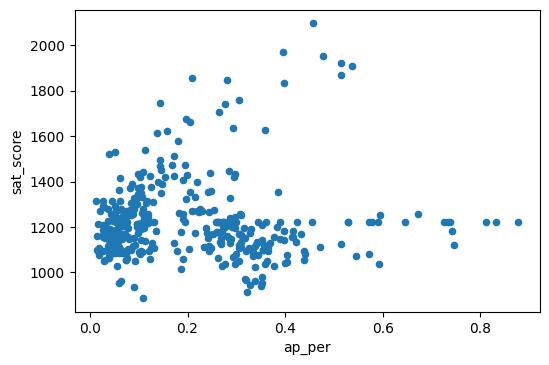

In [63]:
combined.plot.scatter(x = 'ap_per', y = 'sat_score')
plt.show()

We can observe weak positive linear correlation  between ap